<a href="https://colab.research.google.com/github/Louis5228/2020-Machine-Learning/blob/main/hw3_309512014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import cv2
from numpy.linalg import inv, pinv, linalg
from PIL import Image
from scipy.stats import multivariate_normal
import prettytable as pt
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Machine_Learning/HW3/dataset")

x_data = pd.read_csv("gp_x.csv", header=None)
t_data = pd.read_csv("gp_t.csv", header=None)

x_data = np.array(x_data)
t_data = np.array(t_data)

# 1. Gaussian Process for Regression

In [3]:
Num = 50
x_train = x_data[:Num]
t_train = t_data[:Num]
x_test = x_data[Num:]
t_test = t_data[Num:]

theta_config = [[0,  0,  0, 1],
                [1, 16,  0, 0],
                [1, 16,  0, 4],
                [1, 64, 32, 0],
                [8, 256, 0, 0]] # trial and error config
beta_inv = 1

In [4]:
def cal_ker(theta, xn, xm):
  return theta[0] * math.exp(-theta[1]*0.5 * (xn - xm)**2) + theta[2] + theta[3] * xn * xm

def cal_Gaussian(thera, xn, cov_inv):
  k = np.zeros((Num,1))
  for i in range(Num):
    k[i,0] = cal_ker(theta, x_train[i], xn)
  c = cal_ker(theta, xn, xn) + beta_inv
  mean = (k.T).dot(cov_inv).dot(t_train)
  var = c - (k.T).dot(cov_inv).dot(k)
  return mean, var

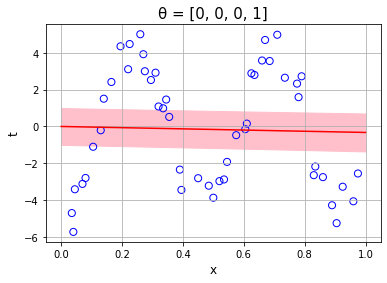

RMS error of training data : 3.1292014298222433
RMS error of testing  data : 3.3443986601861146
--------------------------------------------------


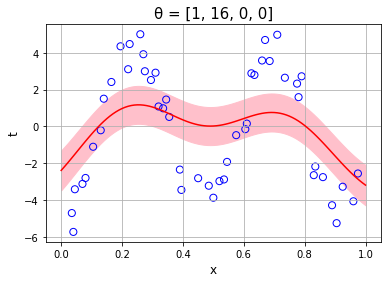

RMS error of training data : 2.4239279278312194
RMS error of testing  data : 2.6680517502524466
--------------------------------------------------


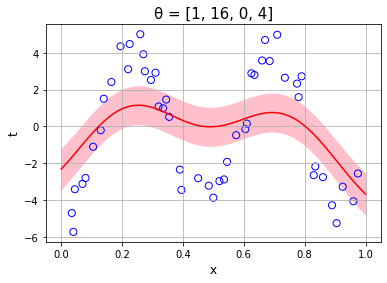

RMS error of training data : 2.410576487125207
RMS error of testing  data : 2.6569980001669165
--------------------------------------------------


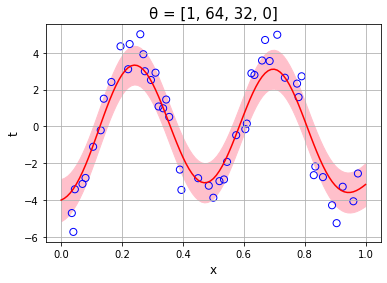

RMS error of training data : 1.0428861621832217
RMS error of testing  data : 1.1627590936118453
--------------------------------------------------


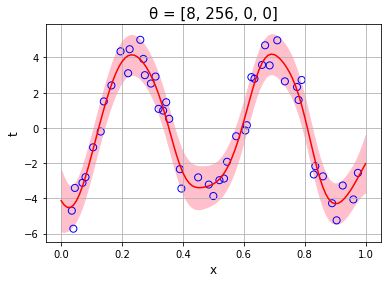

RMS error of training data : 0.6727647429593011
RMS error of testing  data : 1.0411559204230687
--------------------------------------------------


In [5]:
x = np.arange(0, 1.01, 0.01)

for theta in theta_config:
  y = np.zeros(0)
  std = np.zeros(0)
  cov = np.zeros((Num, Num))
  for i in range(Num):
    for j in range(Num):
      cov[i,j] = cal_ker(theta, x_train[i], x_train[j])
      if i == j:
        cov[i,j] += beta_inv
  cov_inv = inv(cov)

  for xn in x:
    mean, var = cal_Gaussian(theta, xn, cov_inv)
    y = np.append(y, mean)
    std = np.append(std, math.sqrt(var))
  
  RMS_err_train = 0
  for i in range(Num):
    mean, var = cal_Gaussian(theta, x_train[i], cov_inv)
    RMS_err_train += (mean - t_train[i])**2
  RMS_err_train = math.sqrt(RMS_err_train / Num)

  RMS_err_test = 0
  for i in range(x_data.shape[0] - Num):
    mean, var = cal_Gaussian(theta, x_test[i], cov_inv)
    RMS_err_test += (mean - t_test[i])**2
  RMS_err_test = math.sqrt(RMS_err_test / (x_data.shape[0] - Num))

  plt.plot(x, y, c='r')    
  plt.fill_between(x, y - std, y + std, color='pink')
  plt.scatter(x_train, t_train, s=50, facecolors='none', edgecolors='b')
  plt.title("θ = " + str(theta), fontsize = 15)
  plt.xlabel("x", fontsize = 12)
  plt.ylabel("t", fontsize = 12)
  plt.grid(True)
  plt.show()
  print("RMS error of training data : " + str(RMS_err_train))
  print("RMS error of testing  data : " + str(RMS_err_test))
  print("-"*50)

# 2. Support Vector Machine ( SVM )

# 3. Gaussian Mixture Model

In [90]:
img = Image.open('imghw3.jpg')
img.load()
img = np.asarray(img, dtype='float')
height, width, depth = img.shape

data = img.reshape((-1, depth)) / 255.0 #(76480, 3)

In [91]:
def K_means(data, K, max_iteration=300):
  mu = data[np.random.choice(len(data), K, replace=False)]
  rnk = np.ones([len(data), K])

  for it in range(max_iteration):
    dists = np.sum((data[:, None] - mu)**2, axis=2)
    n_rnk = np.eye(K)[np.argmin(dists, axis=1)]

    if np.array_equal(n_rnk, rnk):
      break
    else: 
      rnk = n_rnk

    mu = np.sum(n_rnk[:, :, None] * data[:, None], axis=0) / np.sum(n_rnk, axis=0)[:, None]
  return mu, rnk

In [95]:
def print_table(K, mu , _type):
    tb = pt.PrettyTable()
    tb.add_column(_type, [k for k in range(K)])
    tb.add_column('R', [r for r in (mu[:, 0]*255).astype(int)])
    tb.add_column('G', [g for g in (mu[:, 1]*255).astype(int)])
    tb.add_column('B', [b for b in (mu[:, 2]*255).astype(int)])
    print("======= K = %d (%s) =======" % (k, _type))
    print(tb)

In [93]:
def plot_img(mu, rnk, gaussians, _type):
    if _type == 'K_means':
        new_data = (mu[np.where(rnk == 1)[1]]*255).astype(int)
    else:
        new_data = (mu[np.argmax(gaussians, axis=0)]*255).astype(int)
    
    show_img = new_data.reshape((height, width, depth))
    plt.title('K = '+str(k)+' ('+str(_type)+')', fontsize = 15), plt.xticks([]), plt.yticks([])
    plt.imshow(show_img)
    plt.show()
    # disp = Image.fromarray(new_data.reshape(height, width, depth).astype('uint8'))
    # disp.save('/content/gdrive/My Drive/Machine_Learning/HW3/'+_type+str(k)+'.png')

======= K = 3 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    |  73 |  66 |  52 |
|    1    | 133 | 126 | 104 |
|    2    | 194 | 195 | 182 |
+---------+-----+-----+-----+


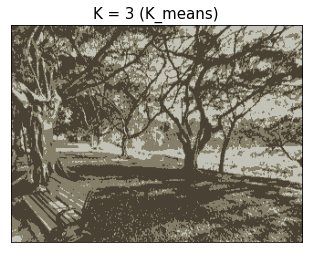

======= K = 5 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    | 214 | 217 | 210 |
|    1    |  93 |  86 |  69 |
|    2    |  59 |  52 |  39 |
|    3    | 133 | 125 | 103 |
|    4    | 169 | 168 | 148 |
+---------+-----+-----+-----+


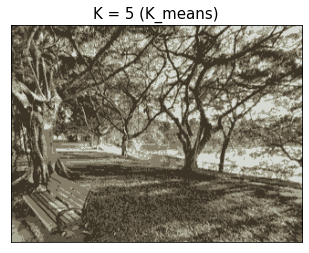

======= K = 7 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    | 222 | 226 | 221 |
|    1    | 159 | 144 | 103 |
|    2    |  53 |  46 |  34 |
|    3    | 133 | 141 | 141 |
|    4    |  83 |  75 |  61 |
|    5    | 184 | 184 | 166 |
|    6    | 115 | 107 |  87 |
+---------+-----+-----+-----+


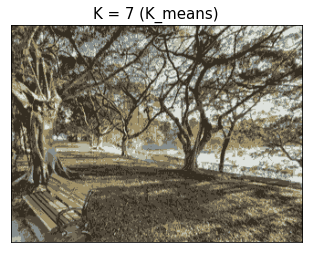

======= K = 10 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    | 231 | 233 | 229 |
|    1    | 188 | 195 | 192 |
|    2    |  44 |  38 |  25 |
|    3    | 118 | 124 | 122 |
|    4    | 155 | 139 | 103 |
|    5    | 151 | 159 | 157 |
|    6    | 119 | 108 |  82 |
|    7    |  70 |  62 |  49 |
|    8    |  91 |  84 |  69 |
|    9    | 199 | 184 | 130 |
+---------+-----+-----+-----+


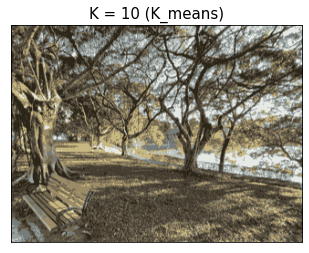

In [96]:
K_l = [3, 5, 7, 10]

for k in K_l:
  k_means_mu, k_means_rnk = K_means(data, k)

  print_table(k, k_means_mu, 'K_means')
  plot_img(k_means_mu, k_means_rnk, None, 'K_means')